# Расчет затрат энергии в распределенной модели по Спенсеру (2012)

 - используем `NEURON`, но всю модель делаем из `Python` (кроме `NMODL`-файлов)
 - подбираем параметры аксональных сегментов так, чтобы модель соответствовала условиям:
  - порог к прямоугольному импульсу около 3 nA
  - порог dV/dt около 10-12 mV/ms
  - может активироваться на частотах около 800 Гц

In [1]:
from itertools import chain

In [2]:
%pylab inline
#%pylab tk

style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [4]:
from neuron import h, gui

h.celsius = 33.0

In [5]:
h.cvode_active(0)
#h.cvode.atol(5e-4)

0.0

In [6]:
# number of segments per dendrite should be large to allow for precise synapse location


Ndend = 4
    
class OctopusCell:
    all_currents = ['leak', 'nasab', 'kltab', 'khtab', 'ihsab']
    def __init__(self, 
                 soma_diam=25.0,
                 ax_init_L=5.0,
                 ax_passive_L=5.0,
                 ax_diam=3.0,
                 Ndend=4, Ndendseg = 201, dend_L=250., dend_diam=3.0,
                 cm = 1.2, # uF/cm^2, closer to McGinley et al 2012
                 Ra = 150., #Ohm*cm, closer to McGinley et al 2012 
                 Eleak=-62):
        self.id = randint(10000000)
        #self.Eleak = Eleak
        self.make_soma(soma_diam)
        self.make_axon(ax_init_L, ax_passive_L,ax_diam)
        self.make_dendrites(Ndend,Ndendseg,dend_L,dend_diam)
        self.make_connections()
        self.init_mechanisms(cm, Ra, Eleak)
        
        self.add_stim()
        self.init_records()
        
    def add_stim(self):
        self.stim = h.IClamp(0.5, sec=self.soma)
        self.stim.amp = 0
        
    def init_records(self):
        istim = h.Vector()
        istim.record(self.stim._ref_i)
        self.istim = istim
        
        self.tv = h.Vector()
        self.tv.record(h._ref_t) 
        
        self.vax = h.Vector()
        self.vax.record(self.ax_init(0.5)._ref_v) 
        
        self.vs = h.Vector()
        self.vs.record(self.soma(0.5)._ref_v) 
        
        
        
    def make_soma(self,diam):
        # Soma
        soma = h.Section()
        soma.L = soma.diam = diam
        soma.nseg = 1
        self.soma = soma

    def make_axon(self, ax_init_len=10, ax_passive_len=30,diam=3.0):
        # Axon
        ax_stub = h.Section()
        ax_init = h.Section()
        ax_stub.diam = ax_init.diam = diam
        ax_stub.L = ax_passive_len
        ax_init.L = ax_init_len
        self.ax_init = ax_init
        self.ax_stub = ax_stub

    def make_dendrites(self,  Ndend=4, Ndendseg=201, L=250, diam=3.0):
        # Dendrites
        dendrites = [h.Section() for i in range(Ndend)]
        for d in dendrites:
            d.diam = 3
            d.L = L
            d.nseg = Ndendseg
            #d.connect(soma, 1, 0)
        self.dendrites = dendrites
    
    def make_connections(self):
        self.ax_init.connect(self.ax_stub, 1, 0)
        self.ax_stub.connect(self.soma, 0, 0)
        for d in self.dendrites:
            d.connect(self.soma, 1, 0)
    
    def init_mechanisms(self, cm, Ra, Eleak):
        sections = [self.soma, self.ax_init, self.ax_stub]+self.dendrites
        for sec in sections:
            sec.Ra = Ra  
            #sec.cm = 0.9      # Spencer
            sec.cm = cm      
            for cur in self.all_currents:
                sec.insert(cur)
            for seg in sec:
                seg.leak.erev = Eleak
                seg.leak.g = 0.002  # Spencer
                #seg.hcno.eh = -38
                seg.ihsab.eh = -38 # Spencer
            
                seg.nasab.gbar = 0
                seg.ihsab.gbar = 0
                seg.kltab.gbar = 0
                seg.khtab.gbar = 0
                #seg.hcno.gbar = 0
            
            sec.ena = 55.0
            sec.ek = -70.0
    
        # ... there must be a more compact way...
        # todo: tabulate these parameters
        for seg in self.ax_init:
            seg.nasab.gbar = 4.244
       
        for seg in self.soma:
            seg.kltab.gbar = 0.0407
            seg.khtab.gbar = 0.0061
            seg.ihsab.gbar = 0.0076
    
        for seg in chain(*self.dendrites):
            seg.kltab.gbar = 2.7e-3 # Table 3 Spencer 2012
            seg.khtab.gbar = 0.6e-3 # Table 3 Spencer 2012
    
    def add_synapses(self,
                     Nsyn = 100, # total number of impinging synapses
                     gsyn = 1.5, # single synaptic conductance nS
                     tau_rise = 0.07,
                     tau_decay = 0.34,
                     #-- 
                     tonotopy = 'ordered', # {ordered, random}
                     full_delay = 0.3, # max difference between delays, ms
                     #--
                     aud_rate=211,    # incoming spike rate, Hz
                     aud_start = 100, # ms
                     aud_npulses=25,  # number of incoming spikes 
                     aud_jitter = 0.0, # jitter of incoming spike times (0...1)
                    ):
        afib = h.NetStim()

        afib.interval = 1000./aud_rate # ms 
        afib.start = aud_start # ms
        afib.number = aud_npulses # number of spikes
        afib.noise = aud_jitter # no randomness so far
        self.afib = afib
        
        synapses = []
        delays = linspace(0,full_delay, Nsyn) # !!! Delay distribution could be non-uniform!
        #delays = uniform(0.0,full_delay,size=Nsyn) # !!! Delay distribution could be non-uniform!
        for k in xrange(Nsyn):
            delay = delays[k]
            if tonotopy == 'ordered':
                loc = 1 - delay/full_delay
            elif tonotopy == 'random':
                loc = uniform()
            d = self.dendrites[randint(len(self.dendrites))]
            syn = h.Exp2Syn(loc, sec=d) 
            syn.tau1 = tau_rise # rise time
            syn.tau2 = tau_decay # decay time
            con  = h.NetCon(afib, syn, 0, delay, gsyn*1e-3) #nS->uS
            synapses.append((syn, con, d(loc)))
        self.synapses = synapses
        return synapses
        
        

In [7]:
oclist = [OctopusCell() for i in range(10)]

In [8]:
for oc in oclist:
    oc.init_records() # need this, or len(oc.tv) will be 0

h.v_init = -60.
h.finitialize()
h.run()

0.0

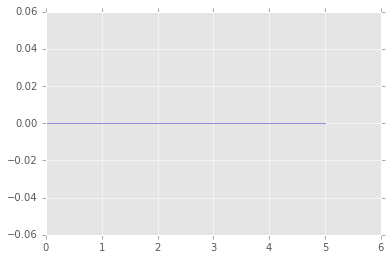

In [9]:
for oc in oclist:
    plot(oc.tv, array(oc.vax)-oclist[0].vax)

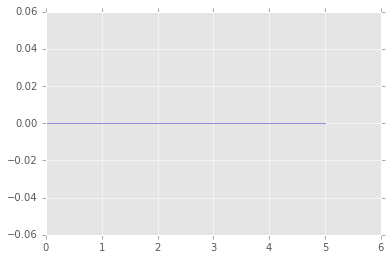

In [10]:
for oc in oclist:
    plot(oc.tv, array(oc.vs)-oclist[0].vs)

In [11]:
del oclist

## Setting axon parameters

Lengths of both passive axon "stub" and the inital axon segment with Na conductance are free parameters in Spencer model and can affect its excitability properties. Let's make some not-so-blue-sky guesses on what these values should be based on responses to rectangular current pulses and current ramps. To this end, we must equip our model with the instrumentation to stimulate and detect thresholds.

In [12]:
def setup_pulse_stim(oc, amp=0, delay=15, dur=3):
    oc.stim.delay = delay
    oc.stim.amp= amp
    oc.stim.dur = dur
    
def setup_ramp_stim(oc, dIdt, Imax=6, delay=15):
    oc.stim.delay = delay
    oc.stim.dur = Imax/float(dIdt) + 1
    oc.stim.amp = Imax
    
    tvx = arange(0, oc.stim.dur + delay, h.dt)
    #print tvx
    
    tvh = h.Vector(tvx)
    oc.tvramp = tvh
    
    iramp = h.Vector(clip((tvx-oc.stim.delay)*dIdt, 0, Imax))
    
    #plot(tvh, iramp)
    
    iramp.play(oc.stim, oc.stim._ref_amp, h.dt)
    # The following *should* but doesn't work for interpolated vector values
    #iramp.play(oc.stim, oc.stim._ref_amp, tvh, 1)
    

    
    oc.iramp = iramp
    
def unset_ramp_stim(oc):
    if hasattr(oc, 'iramp'):
        oc.iramp.play_remove()
    
    

------------------------

In [13]:
def find_threshold(cell, start_range, tol=0.01,
                   vthresh = -25,
                   setter=setup_pulse_stim):
    
    vax = h.Vector()
    vax.record(cell.ax_init(0.5)._ref_v) 
    
    if not hasattr(cell, 'stim'):
        add_single_pulse_stim(cell)
 
    start_range = np.array(map(float, start_range))
    min_range = tol*np.mean(start_range)
  
    def spikep(par):
        setter(cell, par)
        h.tstop = cell.stim.delay + cell.stim.dur + 1.0        
        h.run()
        return array(vax).max()
    
    nfix = 10
    ntries = 0
    while not spikep(start_range[1])>vthresh:
        start_range[1] *= 2.0
        ntries += 1
        if ntries > nfix:
            print "Can't find threshold: max_amp isn't enough!"
            print "Giving up."
            return False
        
    
    def loop(begin, end):
        if end-begin < min_range:
            return end, spikep(end)
        val = np.mean((begin, end))
        if spikep(val) > vthresh:
            return loop(begin, val)
        else:
            return loop(val, end)

    return loop(start_range[0], start_range[1])

In [14]:


def plot_around_th(cell, th, setter=setup_pulse_stim, coefs = [0.95, 1, 1.05]):
    f, axs = subplots(2,1,sharex=True, figsize=(9,9))
    
    tv = h.Vector()
    tv.record(h._ref_t)
    
    istim = h.Vector()
    istim.record(cell.stim._ref_i)

                
    vax = h.Vector()
    vax.record(cell.ax_init(0.5)._ref_v) 
    #vax.record(cell.soma(0.5)._ref_v) 
    
    for c in coefs:
        setter(cell, c*th)
        h.run()
        axs[0].plot(tv, vax,  label='%0.2f th'%c)
        axs[1].plot(tv, istim,'k-')
        setp(axs[1], ylim=(-0.1, amax(array(cell.istim))*1.2))

    axs[0].legend(loc='upper left')
    axs[0].set_ylabel('membrane potential, mV')
    setp(axs[1], xlabel='time, ms', ylabel='Istim')


In [15]:
oc = OctopusCell(Ndendseg=15)
print oc.ax_init.L, oc.ax_stub.L

5.0 5.0


In [16]:
unset_ramp_stim(oc)
setup_pulse_stim(oc)

h.tstop = oc.stim.delay + oc.stim.dur + 1.0

%time th = find_threshold(oc, array([1.,6.]))
print th

CPU times: user 552 ms, sys: 0 ns, total: 552 ms
Wall time: 548 ms
(3.44140625, 1.1665633222164584)


CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 236 ms


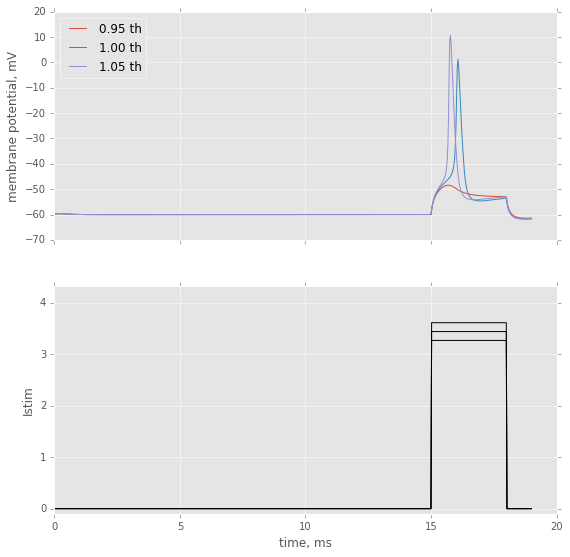

In [17]:
%%time 
plot_around_th(oc, th[0])

In [18]:
from functools import partial

In [19]:
%%time 

fsetter=partial(setup_ramp_stim, Imax=2*th[0])
th2 = find_threshold(oc, array([0.5,10.]), 
                     vthresh = -25,
                     setter=fsetter)
print th2

(2.392578125, -19.645932471869511)
CPU times: user 564 ms, sys: 0 ns, total: 564 ms
Wall time: 564 ms


CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 245 ms


(14, 20)

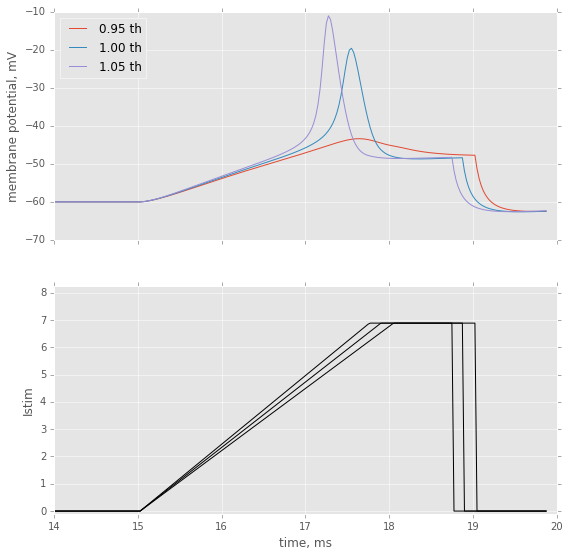

In [20]:
%time plot_around_th(oc, th2[0], setter=fsetter)#, coefs=arange(0.6, 0.7, 0.02))
#for line in gcf().axes[0].lines:
#    setp(line, color='k',alpha=0.5)
xlim(14, 20)

(15, 16.5, -60, -45)

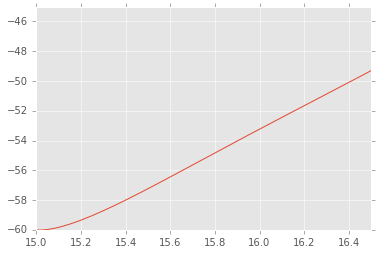

In [21]:
oc.init_records()
h.run()
plot(oc.tv, oc.vax); axis((15,16.5,-60,-45))

In [22]:
atv = array(oc.tv)
av = array(oc.vax)

interv = (atv > 15.2)*(atv<16.5) 
dvr = diff(av[interv])
mean(dvr)/h.dt

7.7665835058998844

## Monte-Carlo look for an admissible range of axonal section lengths

In [23]:
def generate_psets(Ntrials=10,
                   center_act=15.0,
                   center_pass=15.,
                   nhood=15.,
                   variant = 'uniform',
                   domain=[1.0,50.0]):

    active_w = clip(center_act + nhood*array([-1,1]), *domain)
    passive_w = clip(center_act + nhood*array([-1,1]), *domain)
    if variant == 'uniform':
        active_Ls = uniform(*active_w, size=Ntrials)
        passive_Ls = uniform(*passive_w, size=Ntrials)
    elif variant == 'gauss':
        active_Ls = clip(randn(Ntrials)*nhood + center_act, *domain)
        passive_Ls = clip(randn(Ntrials)*nhood + center_pass,*domain)
    psets = [dict(ax_init_L=l1, ax_passive_L=l2) for l1,l2 in zip(active_Ls, passive_Ls)]
    return psets

In [24]:
import sys

In [25]:

def estimate_thresholds(params):
    acc = []
    coef = 2
    for k,p in enumerate(params):
        #print 'set :', k, 'ax_init:', p['ax_init_L'], 'ax_pass:', p['ax_passive_L']
        report =  '\rset #{}: ax_init: {:2.1f}, ax_pass: {:2.1f}, pth.: {:2.1f} nA, \
rth.: {:2.1f} nA/ms, amp: {:2.1f} mV'
        oc = OctopusCell(Ndendseg=15,**p)
        th1,vsp = find_threshold(oc, array([1, 6]))
        th2 = find_threshold(oc, array([0.5,10.]), 
                             setter=lambda c,rate: setup_ramp_stim(c,rate,Imax=coef*th1))[0]

        sys.stderr.write(report.format(k+1, p['ax_init_L'], p['ax_passive_L'], th1, th2, vsp))
        acc.append((th1, th2, vsp))
        oc = None
    return array(acc)

In [ ]:
def mc_search_parameter_space(Niter=10, Nprime=50,  Next=6, Nbest=3,
                              nhood=2.0, 
                              domain = [(1, 30),(1,30)],
                              max_pulse_th=4.0, 
                              min_rate_threshold=4.0,
                              min_peak_vax = -10,
                             ):
    
    
    # Domain corners
    params = [dict(ax_init_L=l1, ax_passive_L=l2) for l1 in domain[0] for l2 in domain[1]] 
    
    # Priming set
    params += generate_psets(Nprime)
    thresholds = estimate_thresholds(params)
    
    def _validate(th):
        return th[0]<=max_pulse_th and th[2]>=min_peak_vax
    
    acc = [(p,t) for p,t in zip(params,thresholds)]
    keep = [(p,t) for p,t in acc if _validate(t)]
    
    
    for i in range(Niter):
        if not len(keep):
            break
        best = sorted(keep, key=lambda p: p[1][1], reverse=True)[:min(len(keep),Nbest)]
        print i, len(acc), best[0]
        ukeep = []
        for pset,th in best:
            params = generate_psets(Next, pset['ax_init_L'], pset['ax_passive_L'],
                                    nhood=nhood, variant='gauss')
            thresholds = estimate_thresholds(params)
            update = [(p,t) for p,t in zip(params, thresholds)]
            acc += update
            ukeep += [(p,t) for p,t in update if _validate(t)]
        if len(ukeep):
            keep = ukeep[:]
    return acc

In [ ]:
%%time

explored = mc_search_parameter_space(Niter=10,Nprime=50)

In [ ]:
#Ntrials = 100
#axinit_Ls = uniform(2, 30, size=Ntrials)
#axstub_Ls = uniform(2, 30, size=Ntrials)

#psets = [dict(ax_init_L=l1, ax_passive_L=l2) for l1,l2 in zip(axinit_Ls, axstub_Ls)]

In [ ]:
#%%time 
#rate_ths = []
#pulse_ths = []
#coef = 2
#for k,p in enumerate(psets):
#    #print 'set :', k, 'ax_init:', p['ax_init_L'], 'ax_pass:', p['ax_passive_L']
#    report =  'set #{}: ax_init: {:2.1f}, ax_pass: {:2.1f}, pulse th.: {:2.1f}, rate th.: {:2.1f}'
#    oc = OctopusCell(Ndendseg=20,**p)
#    th1 = find_threshold(oc, array([1, 6]))
#        
#    th2 = find_threshold(oc, array([0.5,10.]), 
#                         setter=lambda c,rate: setup_ramp_stim(c,rate,Imax=coef*th1))

#    print report.format(k+1, p['ax_init_L'], p['ax_passive_L'], th1, th2)
#    pulse_ths.append(th1)
#    rate_ths.append(th2)
#    oc = None

In [ ]:
from matplotlib.mlab import griddata

In [ ]:
#explored

In [ ]:
xi = np.linspace(1, 30, 200)
yi = np.linspace(1, 30, 200)
# grid the data.

x = [_p['ax_init_L'] for _p,_e in explored]
y = [_p['ax_passive_L'] for _p,_e in explored]

z1 = [_e[0] for _p,_e  in explored]
z2 = [_e[1] for _p,_e  in explored]
z3 = [_e[2] for _p,_e  in explored]



zi1 = griddata(x, y, z1, xi, yi, interp='linear')
zi2 = griddata(x, y, z2, xi, yi, interp='linear')
zi3 = griddata(x, y, z3, xi, yi, interp='linear')

In [ ]:
f, axs = subplots(2,2, sharex=True, sharey=True, figsize=(15,13))

axs = ravel(axs)

CS = axs[0].contour(xi, yi, zi1, [3,6], linewidths=0.5, colors='r')
CS = axs[0].contourf(xi, yi, zi1, 15, cmap='viridis', vmax=max(z1), vmin=0)
plt.colorbar(CS,ax=axs[0])  # draw colorbar

axs[0].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[0], title ='Pulse threshold [nA]', xlabel='ax init segment length [um]',
     ylabel='ax passive segment length [um]')



CS = axs[1].contour(xi, yi, zi2, [4,8], linewidths=0.5, colors='r')
CS = axs[1].contourf(xi, yi, zi2, 15, cmap='viridis', vmax=amax(z2), vmin=0)
plt.colorbar(CS,ax=axs[1])  # draw colorbar

axs[1].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[1], title ='Rate threshold [nA/ms]')


CS = axs[2].contour(xi, yi, zi3, [-15,15], linewidths=0.5, colors='r')
CS = axs[2].contourf(xi, yi, zi3, 25, cmap='viridis', vmax=amax(z3), vmin=amin(z3))
plt.colorbar(CS,ax=axs[2])  # draw colorbar

axs[2].scatter(x, y, marker='.', color='white', s=5)#, zorder=10)
setp(axs[2], title ='AP peak voltage [mV]')


cs = axs[3].imshow((zi2 > 2.5)*(zi1 < 4), extent=(1,30,1,30), origin='lower')
setp(axs[3], title = "Pulse threshold is < 4 nA\n and rate threshold > 2.5 nA/ms")
a = plt.colorbar(cs,ax=axs[3])  # draw colorbar

#xlabel('ax init segment len [um]')
#ylabel('ax passive segment len [um]')

setp(axs[2], xlim=(1,30), ylim=(1,30))
setp(gcf().axes[-1],visible=False)

## Energy calc

In [30]:
def split_mixed(v, gm, erev,ek=-70,ena=55):
    gratio = float((ena-erev))/(erev-ek)
    denom = (v*(gratio+1) - gratio*ek - ena)
    if (abs(v-erev) < 1):
        gnah = gm/(gratio + 1)
    else: 
        gnah = gm*(v-erev)/denom
    inah = gnah*(v-ena)
    ikh = gratio*gnah*(v-ek)
    return inah, ikh


def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def J2atp(nJ):
    "convert from Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3



def mouj_Erate2(seg, erev_ih = -38):
    v = seg.v
    acc = 0.0
    inah, ikh = split_mixed(seg.v, seg.gh_ihsab, erev_ih, seg.ek, seg.ena) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

def synaptic_curr2pJ(syn,seg):
    # syn.g is in uS, syn.i is in nA, erate is in pJ/s
    v  = seg.v
    g = syn.g
    ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena)
    erate = ina*(v-seg.ena) + ik*(v-seg.ek)
    return erate

## Adding synapses

In [31]:
oc1 = OctopusCell()
oc2 = OctopusCell()

Nsyn = 252
gsyn = 1.1
rate = 256.

s1 = oc1.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy='ordered')
s2 = oc2.add_synapses(Nsyn=Nsyn, gsyn=gsyn, aud_rate=rate, tonotopy='random')

In [32]:
oc1.init_records()
oc2.init_records()
h.tstop = 500
h.v_init = -60.0
%time h.run()

CPU times: user 55.4 s, sys: 0 ns, total: 55.4 s
Wall time: 55.4 s


0.0

(90, 220)

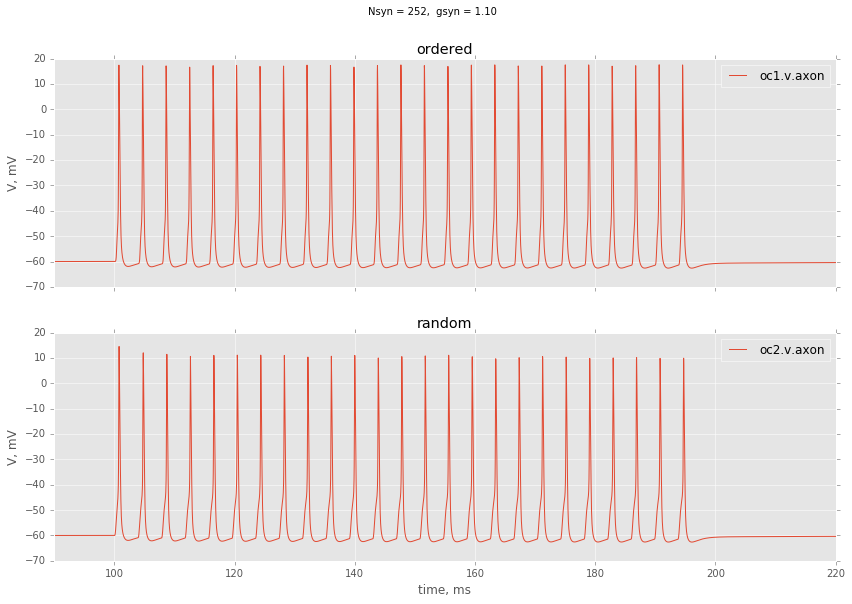

In [33]:
f, axs=subplots(2,1, sharex=True, sharey=True, figsize=(14,9))
axs[0].plot(oc1.tv, oc1.vax, label='oc1.v.axon')
axs[0].legend()

axs[1].plot(oc2.tv, oc2.vax, label='oc2.v.axon')
axs[1].legend()


setp(axs[0], title='ordered', ylabel='V, mV')
setp(axs[1], title='random', ylabel='V, mV', xlabel='time, ms')

suptitle('Nsyn = %d,  gsyn = %1.2f'%(Nsyn, gsyn))
xlim(90,220)

In [34]:
apc = h.APCount() # use this to count spikes! 

In [118]:
%%time 
tv = array(oc2.tv)
acc = []
gv = linspace(2.0, 2.5, 5)

for gsyn in gv:
    print gsyn
    for s,c,d in oc2.synapses:
        c.weight[0] = gsyn*1e-3
    oc2.init_records()
    h.run()
    acc.append(array(oc2.vax))
            

2.0
2.125
2.25
2.375
2.5
CPU times: user 6min 11s, sys: 28 ms, total: 6min 12s
Wall time: 6min 12s


(90, 190)

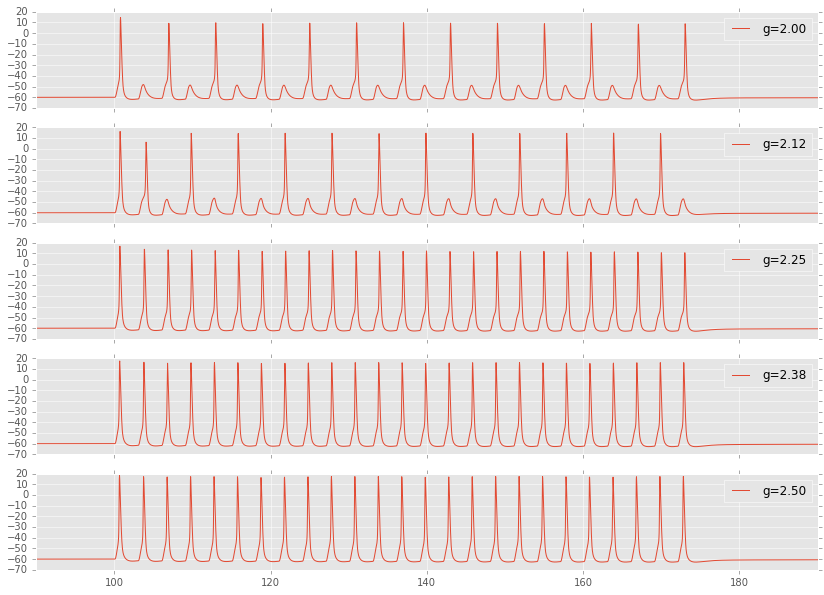

In [119]:
f, axs = subplots(len(acc),1, sharex=True, sharey=True, figsize=(14,10))

for ax, v, g in zip(axs, acc, gv):
    ax.plot(tv, v, label='g=%1.2f'%g)
    ax.legend()
xlim(90,190)

In [90]:
c.weight[0]

0.002

## Run control from Python and energy accounting

In [ ]:
h.dt = 0.01
tstop = 300

h.v_init = -60.6

def initialize():
    h.finitialize(h.v_init)
    h.fcurrent()

    
def instant_erates(cell):
    syn_erate = np.sum([synaptic_curr2pJ(s,dseg) for s,c,dseg in cell.synapses])
    soma_erate = mouj_Erate2(cell.soma(0.5))
    dend_erate = np.sum([mouj_Erate2(seg) for seg in chain(*cell.dendrites)])
    axon_erate = np.sum([mouj_Erate2(seg) for seg in chain(cell.ax_init,cell.ax_stub)])
    return axon_erate, soma_erate, dend_erate, syn_erate
    
    
def integrate_collecting_energy(cells):

    keepvar = ['t','soma.v','axon.v',
               'soma.erate','axon.erate','dend.erate', 'syn.erate']
    outs = [{key:[] for key in keepvar} for i in range(len(cells))]

    while h.t < tstop:
        h.fadvance()
        #isyn = np.sum([syn.i for syn in synapses])
        
        erates = map(instant_erates, cells)
        
        for cell, o, erate in zip(cells, outs, erates):
            o['t'].append(h.t)
            o['axon.v'].append(cell.ax_init.v)
            o['soma.v'].append(cell.soma.v)
            o['axon.erate'].append(erate[0])
            o['soma.erate'].append(erate[1])
            o['dend.erate'].append(erate[2])
            o['syn.erate'].append(erate[3])

    return [{key:np.array(vec) for key,vec in out.items()} for out in outs]

def go(cells):
    initialize()
    return integrate_collecting_energy(cells)
    
def plot_traj(traj):
    f, axs = subplots(2,1,sharex=True, figsize=(14,9),)
    #axs = [axs]
    axs[0].plot(traj['t'], traj['axon.v'],'r-',lw=0.5,label='axon.v')
    axs[0].plot(traj['t'], traj['soma.v'],'b-',label='soma.v')
    axs[0].legend()
    
    axs[1].plot(traj['t'], traj['soma.erate'], '-', label='soma.erate')
    axs[1].plot(traj['t'], traj['dend.erate'], '-', label='dend.erate')
    axs[1].plot(traj['t'], traj['axon.erate'], '-', label='axon.erate')
    axs[1].plot(traj['t'], traj['syn.erate'], '-', color='orange', label='syn.erate')
    axs[1].legend()

In [ ]:
%time data = go()

In [ ]:
plot_traj(data)

In [ ]:
plot_traj(data)
xlim(100, 103)

In [ ]:
plot_traj(data)
xlim(214, 217)